In [2]:
import pyLDT_cosmo.pyLDT as pyLDT
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# input section
z = np.array([0., 0.5, 1.]) # output redshifts
R = np.array([10., 15., 20.]) # radius of top-hat smoothing filter in Mpc/h
######## MG flags ########
want_fr = True # compute f(R) gravity PDF
want_dgp = True # compute nDGP PDF
######## Non-linear variances for mu = log(rho) in fiducial LCDM cosmology ########
cosmo_params_fid = {'Omega_m': 0.31315, 'Omega_b': 0.0492, 'A_s': 2.0968e-9, 'n_s': 0.9652, 'h': 67.37} # fiducial LCDM cosmology; if changed, also update non-linear variances below
# The matrix s2_mu_gr_fid[i,j] gives non-linear variances for smoothing radius R[i] and redshift z[j]
# Only fiducial GR values are needed: corresponding values for MG and other LCDM cosmologies can be 
# accurately derived (<0.2%) using Eq. 14 in 1911.11158
s2_mu_gr_fid = np.array([[0.391930, 0.252758, 0.166748], 
                         [0.232552, 0.144374, 0.092990], 
                         [0.149381, 0.090940, 0.057913]]) # update this if new redshifts and/or radii available, or if changing fiducial cosmology
sig2_gr_fid = pyLDT.init_fid(cosmo_params_fid, z) # Compute linear variance for fiducial cosmology

In [11]:
# Set cosmological parameters
cosmo_params = {'Omega_m': 0.31315, 'Omega_b': 0.0492, 'A_s': 2.0968e-9, 'n_s': 0.9652, 'h': 67.37, 'fR0': -1e-5, 'n': 1., 'rcH0': 0.5}
# Compute matter PDF for requested models
# The output is a dictionary with keys 'gr', 'fr' and 'dgp'. Each value is a matrix [i][j] 
# where [i] runs over (increasing) smoothing radius and [j] over (increasing) redshifts
pdf_mat = pyLDT.compute_pdf(cosmo_params, z, R, sig2_gr_fid, s2_mu_gr_fid, want_fr, want_dgp)
# pdf_mat = pyLDT.compute_pdf(cosmo_params, cosmo_params_fid, z, R, s2_mu_gr_fid, want_fr, want_dgp) we want something like this instead, where init_fid is just an internal computation

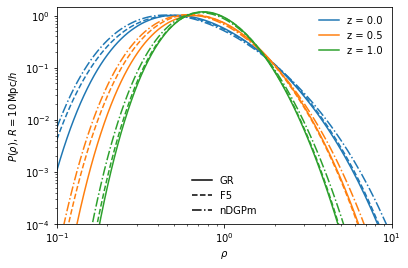

In [18]:
# plot PDFs for various redshifts
rho = np.logspace(-1,1,100)

plt.xlabel(r'$\rho$')
plt.ylabel(r'$P(\rho)$, $R = 10 \, {\rm Mpc}/h$')
plt.xlim(1e-1,10)
plt.ylim(1e-4,1.5)
plt.xscale('log')
plt.yscale('log')
line = [None for _ in range(len(z))]
for i in range(len(z)):
    line[i], = plt.plot(rho,pdf_mat['gr'][0][i](rho), color='C'+str(i), label='z = '+str(z[i]))
    plt.plot(rho,pdf_mat['fr'][0][i](rho), color='C'+str(i), linestyle='dashed')
    plt.plot(rho,pdf_mat['dgp'][0][i](rho), color='C'+str(i), linestyle='dashdot')
z_legend = plt.legend(handles=line, loc="best", frameon=False)
ax = plt.gca().add_artist(z_legend)
gr_style, = plt.plot(rho,np.zeros(rho.shape), color='k', label='GR')
fr_style, = plt.plot(rho,np.zeros(rho.shape), color='k', linestyle='dashed', label=r'F5')
dgp_style, = plt.plot(rho,np.zeros(rho.shape), color='k', linestyle='dashdot', label='nDGPm')
plt.legend(handles=[gr_style,fr_style,dgp_style], loc='lower center', frameon=False)

plt.show()

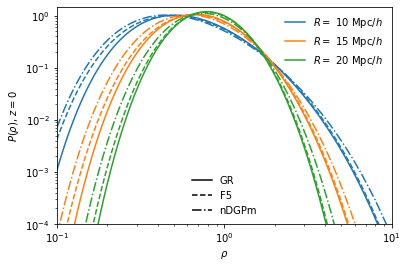

In [19]:
# plot PDFs for various smoothing radii
plt.xlabel(r'$\rho$')
plt.ylabel(r'$P(\rho)$, $z = 0$')
plt.xlim(1e-1,10)
plt.ylim(1e-4,1.5)
plt.xscale('log')
plt.yscale('log')
line = [None for _ in range(len(R))]
for i in range(len(R)):
    line[i], = plt.plot(rho,pdf_mat['gr'][i][0](rho), color='C'+str(i), label=r'$R =$ '+str(int(R[i]))+r' Mpc/$h$')
    plt.plot(rho,pdf_mat['fr'][i][0](rho), color='C'+str(i), linestyle='dashed')
    plt.plot(rho,pdf_mat['dgp'][i][0](rho), color='C'+str(i), linestyle='dashdot')
R_legend = plt.legend(handles=line, loc='upper right', frameon=False)
ax = plt.gca().add_artist(R_legend)
gr_style, = plt.plot(rho,np.zeros(rho.shape), color='k', label='GR')
fr_style, = plt.plot(rho,np.zeros(rho.shape), color='k', linestyle='dashed', label=r'F5')
dgp_style, = plt.plot(rho,np.zeros(rho.shape), color='k', linestyle='dashdot', label='nDGPm')
plt.legend(handles=[gr_style,fr_style,dgp_style], loc='lower center', frameon=False)

plt.show()